In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import gymnasium as gym
from gymnasium import spaces

import collections

from dm_control import mujoco, viewer, suite
from dm_control.rl import control
from dm_control.suite import base, common
from dm_control.suite.utils import randomizers
from dm_control.utils import rewards
from dm_control.utils import io as resources
from dm_env import specs
import numpy as np
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

# Env:

In [45]:
TASKS = [('reach_top_left', np.array([-0.15, 0.15, 0.01])),
         ('reach_top_right', np.array([0.15, 0.15, 0.01])),
         ('reach_bottom_left', np.array([-0.15, -0.15, 0.01])),
         ('reach_bottom_right', np.array([0.15, -0.15, 0.01]))]


class MultiTaskPointMassMaze(base.Task):
    """A point_mass `Task` to reach target with smooth reward."""
    def __init__(self, target_id, random=None):
        """Initialize an instance of `PointMassMaze`.

    Args:
      randomize_gains: A `bool`, whether to randomize the actuator gains.
      random: Optional, either a `numpy.random.RandomState` instance, an
        integer seed for creating a new `RandomState`, or None to select a seed
        automatically (default).
    """
        self._target = TASKS[target_id][1]
        super().__init__(random=random)

    def initialize_episode(self, physics):
        """Sets the state of the environment at the start of each episode.

       If _randomize_gains is True, the relationship between the controls and
       the joints is randomized, so that each control actuates a random linear
       combination of joints.

    Args:
      physics: An instance of `mujoco.Physics`.
    """
        randomizers.randomize_limited_and_rotational_joints(
            physics, self.random)
        physics.data.qpos[0] = np.random.uniform(-0.29, -0.15)
        physics.data.qpos[1] = np.random.uniform(0.15, 0.29)
        #import ipdb; ipdb.set_trace()
        physics.named.data.geom_xpos['target'][:] = self._target
        

        super().initialize_episode(physics)

    def get_observation(self, physics):
        """Returns an observation of the state."""
        obs = collections.OrderedDict()
        obs['position'] = physics.position()
        obs['velocity'] = physics.velocity()
        return obs
    
    def get_reward_spec(self):
        return specs.Array(shape=(1,), dtype=np.float32, name='reward')

    def get_reward(self, physics):
        """Returns a reward to the agent."""
        target_size = .015
        control_reward = rewards.tolerance(physics.control(), margin=1,
                                       value_at_margin=0,
                                       sigmoid='quadratic').mean()
        small_control = (control_reward + 4) / 5
        near_target = rewards.tolerance(physics.mass_to_target_dist(self._target),
                                bounds=(0, target_size), margin=target_size)
        reward = near_target * small_control
        return reward



class Physics(mujoco.Physics):
    """physics for the point_mass domain."""

    def mass_to_target_dist(self, target):
        """Returns the distance from mass to the target."""
        d = target - self.named.data.geom_xpos['pointmass']
        return np.linalg.norm(d)

In [46]:

def convert_dm_control_to_gym_space(dm_control_space):
    r"""Convert dm_control space to gym space. """
    if isinstance(dm_control_space, specs.BoundedArray):
        space = spaces.Box(low=dm_control_space.minimum, 
                           high=dm_control_space.maximum, 
                           dtype=dm_control_space.dtype)
        assert space.shape == dm_control_space.shape
        return space
    elif isinstance(dm_control_space, specs.Array) and not isinstance(dm_control_space, specs.BoundedArray):
        space = spaces.Box(low=-float('inf'), 
                           high=float('inf'), 
                           shape=dm_control_space.shape, 
                           dtype=dm_control_space.dtype)
        return space
    elif isinstance(dm_control_space, dict):
        space = spaces.Dict({key: convert_dm_control_to_gym_space(value)
                             for key, value in dm_control_space.items()})
        return space


class DMSuiteEnv(gym.Env):
    def __init__(self, env):
        self.env = env
        self.metadata = {'render.modes': ['human', 'rgb_array'],
                         'video.frames_per_second': round(1.0/self.env.control_timestep())}

        self.observation_space = convert_dm_control_to_gym_space(self.env.observation_spec())
        self.action_space = convert_dm_control_to_gym_space(self.env.action_spec())
        self.viewer = None
    
    def seed(self, seed):
        return self.env.task.random.seed(seed)
    
    def step(self, action):
        timestep = self.env.step(action)
        observation = timestep.observation
        reward = timestep.reward
        done = timestep.last()
        info = {}
        truncated = False
        return observation, reward, done, truncated, info
    
    def reset(self, seed=None, options=None):
        timestep = self.env.reset()
        return timestep.observation, {}
    
    def render(self, mode='human', **kwargs):
        if 'camera_id' not in kwargs:
            kwargs['camera_id'] = 0  # Tracking camera
        use_opencv_renderer = kwargs.pop('use_opencv_renderer', False)
        
        img = self.env.physics.render(**kwargs)
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            if self.viewer is None:
                if not use_opencv_renderer:
                    from gym.envs.classic_control import rendering
                    self.viewer = rendering.SimpleImageViewer(maxwidth=1024)
                else:
                    from . import OpenCVImageViewer
                    self.viewer = OpenCVImageViewer()
            self.viewer.imshow(img)
            return self.viewer.isopen
        else:
            raise NotImplementedError

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None
        return self.env.close()
    
    
class FlattenObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        
        # Flatten the observation space by combining the shapes of each dictionary entry
        self.observation_space = gym.spaces.Box(
            low=-np.inf, 
            high=np.inf, 
            shape=(self.flatten_observation_space_shape(),), 
            dtype=np.float32
        )

    def flatten_observation_space_shape(self):
        # Calculate the total number of elements in the observation space after flattening
        total_shape = 0
        for key in self.observation_space.spaces:
            total_shape += np.prod(self.observation_space.spaces[key].shape)
        return total_shape

    def observation(self, obs):
        # Flatten the dictionary of numpy arrays into a single vector
        return np.concatenate([obs[key].flatten() for key in obs], axis=0)
    
def flat_obs(obs):
    return np.concatenate([obs[key].flatten() for key in obs], axis=0)

In [47]:
# target_id = 3

# xml = resources.GetResource(f'mazes/point_mass_maze_{TASKS[target_id][0]}.xml')
# physics = Physics.from_xml_string(xml, common.ASSETS)
# task = MultiTaskPointMassMaze(target_id=target_id)

# dm_env = control.Environment(
#     physics,
#     task,
#     time_limit=20,
# )

# viewer.launch(dm_env)

# Halfcheetah:

In [48]:
from brax.io import torch as io_torch
import random

class TorchGymWrapper:
    def __init__(self, env, num_envs):
        
        self.env = env
        self.num_envs = num_envs
        self.state_dim = env.observation_space.shape[-1]
        self.action_dim = env.action_space.shape[-1]
        
        
        pass
    
    def reset(self, seed=None):        
        state, _ = self.env.reset()
        return torch.tensor(state, dtype=torch.float32), {}
    
    def step(self, action: torch.Tensor):
        
        action = action.cpu().tolist()
        observation, reward, terminated, truncated, _ = self.env.step(action)
        done = (terminated | truncated)
        
        # state_descriptor = [(int(5 in env_.data.contact.geom2), int(8 in env_.data.contact.geom2)) for env_ in self.env.envs]  
        
        observation = torch.tensor(observation, dtype=torch.float32)
        reward = torch.tensor(reward, dtype=torch.float32)
        done = torch.tensor(done, dtype=torch.float32)
        # state_descriptor = torch.tensor(state_descriptor, dtype=torch.float32)
                
        return observation, reward, terminated, truncated, {}
        

In [49]:
# # env = gym.vector.make('HalfCheetah-v4', render_mode = "rgb_array", num_envs=8)

# max_episode_steps = 1000
# num_envs = 8
# env_fns = [lambda: gym.make('HalfCheetah-v4', render_mode="rgb_array", max_episode_steps=max_episode_steps) for _ in range(num_envs)]
# base_env = gym.vector.SyncVectorEnv(env_fns)
# env = TorchGymWrapper(base_env, num_envs=num_envs)

# state_dim = env.state_dim
# action_dim = env.action_dim

# PPO:

In [50]:
# def make_env():
#     # dm_env = control.Environment(
#     #     physics,
#     #     task,
#     #     time_limit=20,
#     # )
#     dm_env = suite.load(domain_name="point_mass", task_name="easy")
#     env = DMSuiteEnv(dm_env)
#     env = FlattenObservation(env)
#     env = gym.wrappers.TimeLimit(env, max_episode_steps=20)
#     return env

# env = gym.vector.SyncVectorEnv([lambda: make_env() for _ in tqdm(range(32))])

# state, _ = env.reset()
# for _ in tqdm(range(1000)):
#     action = env.action_space.sample()
#     next_state, reward, done, truncated, info = env.step(action)
#     break

In [51]:
def compute_gae_parallel(dones, rewards, values, next_values, gamma=0.99, lambda_=0.95):
    assert (
        dones.shape == rewards.shape == values.shape == next_values.shape
    ), "All inputs must have the same shape (num_envs, sequence_length)."

    num_envs, seq_len = dones.shape
    advantages = torch.zeros_like(rewards, dtype=torch.float32)
    returns = torch.zeros_like(rewards, dtype=torch.float32)
    last_advantage = torch.zeros(num_envs, dtype=torch.float32)
    last_return = torch.zeros(num_envs, dtype=torch.float32)

    for t in reversed(range(seq_len)):
        mask = 1.0 - dones[:, t]
        last_value = next_values[:, t] * mask
        last_advantage = last_advantage * mask
        last_return = last_return * mask

        delta = rewards[:, t] + gamma * last_value - values[:, t]
        last_advantage = delta + gamma * lambda_ * last_advantage
        last_return = rewards[:, t] + gamma * last_return

        advantages[:, t] = last_advantage
        returns[:, t] = last_return

    return advantages, returns


def post_process(action):
    # return torch.tanh(action)
    return torch.clip(action, -1, 1)


def collect_trajectories(env, model, n_steps):

    # state_dim, action_dim = env.single_observation_space.shape[0], env.single_action_space.shape[0]
    state_dim, action_dim = env.state_dim, env.action_dim
    
    states = torch.zeros((env.num_envs, n_steps, state_dim), dtype=torch.float32)
    actions = torch.zeros((env.num_envs, n_steps, action_dim), dtype=torch.float32)
    rewards = np.zeros((env.num_envs, n_steps), dtype=np.float32)
    log_ps = torch.zeros((env.num_envs, n_steps), dtype=torch.float32)
    state_values = torch.zeros((env.num_envs, n_steps), dtype=torch.float32)
    dones = np.zeros((env.num_envs, n_steps), dtype=np.float32)

    state, _ = env.reset()
    

    total_reward = 0
    step_count = 0

    for s in range(n_steps):
        state = torch.tensor(state).to(device)
        action, log_p, state_value, entropy = model(state)
        next_state, reward, terminated, truncated, _ = env.step(post_process(action).cpu())
        done = terminated | truncated

        states[:, s] = state.cpu()
        actions[:, s] = action.cpu()
        rewards[:, s] = reward
        log_ps[:, s] = log_p.cpu().detach()
        state_values[:, s] = state_value.cpu().detach().reshape(-1)
        dones[:, s] = done

        state = next_state

    
    critic_x = torch.tensor(next_state).to(device)
    next_value = model.critic(critic_x).cpu()
    next_state_values = torch.concatenate((state_values[:, 1:], next_value), dim=-1)
    
    rewards, dones = torch.tensor(rewards), torch.tensor(dones)
    advantages, returns = compute_gae_parallel(dones, rewards, state_values, next_state_values)
        
            
    trajectories = {
        # "descriptors": condition_descriptor.unsqueeze(1).repeat(1, n_steps, 1).reshape(-1, BEHAVIOR_DIM**2),
        "states" :  states.reshape(-1, state_dim).detach(),
        "actions" : actions.reshape(-1, action_dim).detach(),
        "rewards" : rewards.reshape(-1).detach(),
        "dones" : dones.reshape(-1).detach(),
        "log_ps" : log_ps.reshape(-1).detach(),
        "state_values": state_values.reshape(-1).detach(),
        "next_state_values": next_state_values.reshape(-1).detach(),
        "returns" : returns.reshape(-1).detach(),
        "advantages" : advantages.reshape(-1).detach(),
        
    }
    
    return trajectories


# trajectories = collect_trajectories(env, model, n_steps=128)

# for key in trajectories:
#     print(key, trajectories[key].shape)

def shufffle_trajectory(trajectories):
    length = trajectories['states'].shape[0]
    permutation = torch.randperm(length)

    shuffled_trajectories = {key: tensor[permutation] for key, tensor in trajectories.items()}
    return shuffled_trajectories

# shuffled_trajectories = shufffle_trajectory(trajectories)

In [52]:
def ppo_optimization(trajectories, model, optimizer, epochs, batch_size):
    
    model.train()
    
    traj_states = trajectories["states"]
    traj_actions = trajectories["actions"]
    traj_log_ps = trajectories["log_ps"]
    traj_returns = trajectories["returns"]  
    traj_advantages = trajectories["advantages"]


    len_trajectory = traj_states.shape[0]

    for epoch in range(1, epochs+1):
        for i in range(len_trajectory // batch_size):
            state = traj_states[batch_size*i:batch_size*(i+1)].to(device)
            action = traj_actions[batch_size*i:batch_size*(i+1)].to(device)
            log_p = traj_log_ps[batch_size*i:batch_size*(i+1)].to(device)
            return_ = traj_returns[batch_size*i:batch_size*(i+1)].to(device)
            advantage = traj_advantages[batch_size*i:batch_size*(i+1)].to(device)
            
            new_action, new_log_p, new_state_value, entropy = model(state, action)
            assert(new_action == action).all()
            
            
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
                    
            new_log_p, log_p, advantage = new_log_p.reshape(-1), log_p.reshape(-1), advantage.reshape(-1)
            
            
            
            ratio = torch.exp(new_log_p - log_p.detach())
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-0.2, 1+0.2) * advantage
            policy_loss = - torch.min(surr1, surr2).mean()
            
            # print(advantage[:100])
            # print(ratio[:100])
            # print(policy_loss)
            
            
            return_, new_state_value = return_.reshape(-1), new_state_value.reshape(-1)

            value_loss = ((return_ - new_state_value)**2).mean()

            loss = policy_loss - 2e-7*entropy.mean() + 0.5*value_loss

            optimizer.zero_grad()
            loss.backward()
            clip_factor = torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            
    return entropy.mean().item()
            
# ppo_optimization(trajectories, model, optimizer, epochs=1, batch_size=5)

In [67]:
class ActorCriticContinuous(nn.Module):
    def __init__(self, state_dim, action_dim, actor_hidden_layers, critic_hidden_layers, action_std=0.5):
        super(ActorCriticContinuous, self).__init__()
        
        # Define actor network
        actor_layers = []
        input_dim = state_dim
        for hidden_dim in actor_hidden_layers:
            actor_layers.append(nn.Linear(input_dim, hidden_dim))
            actor_layers.append(nn.ReLU())
            input_dim = hidden_dim
        actor_layers.append(nn.Linear(input_dim, action_dim))
        self.actor = nn.Sequential(*actor_layers)
        
        # Define critic network
        critic_layers = []
        input_dim = state_dim
        for hidden_dim in critic_hidden_layers:
            critic_layers.append(nn.Linear(input_dim, hidden_dim))
            critic_layers.append(nn.ReLU())
            input_dim = hidden_dim
        critic_layers.append(nn.Linear(input_dim, 1))
        self.critic = nn.Sequential(*critic_layers)
        
        self.action_var = nn.Parameter(torch.full((action_dim,), action_std**2, requires_grad=True))


    def forward(self, x, action=None):
        action_mean = self.actor(x)
        cov_matrix = torch.exp(self.action_var)
        dist = torch.distributions.Normal(loc=action_mean, scale=cov_matrix)
        
        if action is None:
            action = dist.sample()
            
        log_p = dist.log_prob(action).sum(dim=-1)
        
        value = self.critic(x)
        
        return action, log_p, value, dist.entropy()

In [89]:
from types import MethodType
from dm_control.utils import rewards

def make_env():
    # dm_env = control.Environment(
    #     physics,
    #     task,
    #     time_limit=20,
    # )
    dm_env = suite.load(domain_name="point_mass", task_name="easy")
    
    env = DMSuiteEnv(dm_env)
    env = FlattenObservation(env)
    env = gym.wrappers.TimeLimit(env, max_episode_steps=1000)
    return env

env = gym.vector.SyncVectorEnv([lambda: make_env() for _ in tqdm(range(8))])
env.state_dim = 4
env.action_dim = 2


def get_reward(self, physics):
    """Returns a reward to the agent."""
    return 1 - physics.mass_to_target_dist()

for inner_env in env.envs:
    inner_env.unwrapped.env.task.get_reward = MethodType(get_reward, inner_env.unwrapped.env.task.get_reward)

100%|██████████| 8/8 [00:00<00:00, 203360.19it/s]


In [90]:
model = ActorCriticContinuous(
    state_dim=4,
    action_dim=2,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256]
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003)

In [ ]:
def get_reward_from_trajectory(trajectory):
    reward_list = []
    acc_reward = 0
    for i in range(len(trajectory['rewards'])):
        if trajectory['dones'][i] == True:
            reward_list.append(acc_reward)
            acc_reward = 0
        
        acc_reward += trajectory['rewards'][i]
    return np.mean(reward_list)

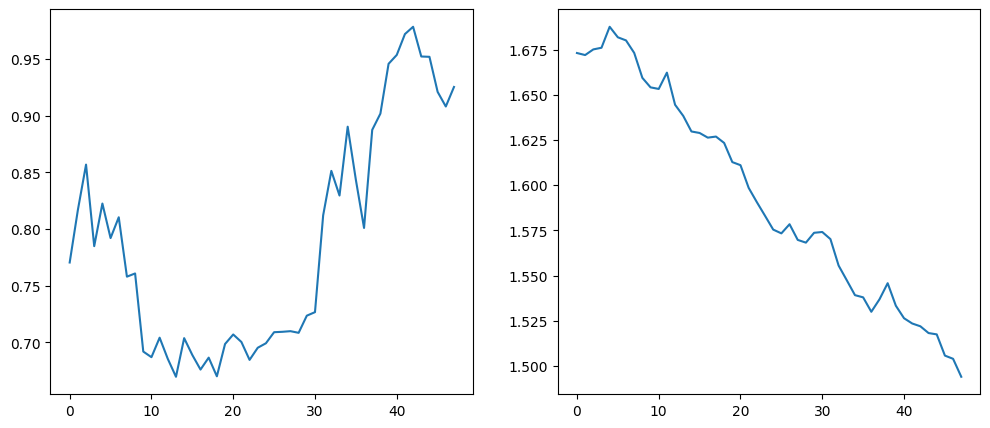

  5%|▍         | 48/1000 [03:59<1:19:03,  4.98s/it]


KeyboardInterrupt: 

In [92]:
rewards = []
entropies = []

for epoch in tqdm(range(1000)):
    trajectory = collect_trajectories(env, model, n_steps=1000*4)
    shuffled_trajectory = shufffle_trajectory(trajectory)
    entropy = ppo_optimization(shuffled_trajectory, model, optimizer, epochs=5, batch_size=256)


    avg_reward = trajectory['rewards'][trajectory['dones'].bool()].mean()
    # avg_reward = trajectory['rewards'].mean()
    # avg_reward = get_reward_from_trajectory(trajectory)
    
    rewards.append(avg_reward)
    entropies.append(entropy)
    
    if epoch % 1 == 0:
        clear_output(True)
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        axs[0].plot(rewards)
        axs[1].plot(entropies)
        plt.show()
        

In [ ]:
# torch.save(model.state_dict(), 'ppo_model.pth')

In [62]:
dm_env = suite.load(domain_name="point_mass", task_name="easy")

# from types import MethodType
# from dm_control.utils import rewards

# def get_reward(self, physics):
#     """Returns a reward to the agent."""
#     return 1 - physics.mass_to_target_dist()
# dm_env.task.get_reward = MethodType(get_reward, dm_env.task.get_reward)

eval_env = DMSuiteEnv(dm_env)
eval_env = FlattenObservation(eval_env)
eval_env = gym.wrappers.TimeLimit(eval_env, max_episode_steps=20)

In [84]:
c = 0
def random_policy(time_step):
    global c
    print(c)
    c += 1
    obs = flat_obs(time_step.observation)
    with torch.no_grad():
        action, *_ = model(torch.tensor(obs).unsqueeze(0).float().to(device))
    action = post_process(action)
    action = action[0].cpu().numpy()
    # return env.action_spec().minimum + (env.action_spec().maximum - env.action_spec().minimum) * np.random.rand(*env.action_spec().shape)
    return action

viewer.launch(eval_env.unwrapped.env, policy=random_policy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27